## Module imports

In [1]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, IncrementalPCA, FastICA, FactorAnalysis, DictionaryLearning, SparseCoder
from importlib import reload
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.transforms import Compose, ToPILImage
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')
from matplotlib import rcParams; rcParams['font.family'] = 'serif'
import clip
from tqdm.notebook import tqdm

# local imports
from data import subset, simple_DS
import valuation 
reload(valuation)
from valuation import get_volume, get_value
import utils

## Make buyer and seller datasets

In [2]:
root = Path('../data/') # path to data directory
download = True # dowload data if dataset does not exist in data directory

# ds = SVHN(root=root, download=download) 
mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion_seller = FashionMNIST(root=root, train=False, download=download)
cifar_seller = CIFAR10(root=root, train=False, download=download)
emnist_seller = EMNIST(root=root, split='byclass', train=False, download=download)

Files already downloaded and verified


### load pretrained model to embed data

In [38]:
torch.load(saved_embedding_path / 'clip_embedding_mnist_buyer.pt')

{'images': tensor([[ 0.3086, -0.7480, -0.0319,  ...,  0.1158,  0.2400,  0.3765],
         [ 0.1680, -0.7603, -0.1332,  ...,  0.1152,  0.2651,  0.1731],
         [ 0.1626, -0.7944,  0.1523,  ...,  0.1675,  0.3289,  0.1932],
         ...,
         [ 0.2881, -0.9531,  0.1172,  ...,  0.1244,  0.3645,  0.1559],
         [ 0.4651, -0.7544,  0.0200,  ...,  0.2185,  0.1586,  0.2595],
         [ 0.4409, -0.7979,  0.0723,  ...,  0.2224,  0.2290,  0.2277]],
        dtype=torch.float16),
 'labels': tensor([7, 2, 1,  ..., 4, 5, 6])}

In [3]:
num_samples = 10000
use_precomputed_embeddings = True
if use_precomputed_embeddings:
    saved_embedding_path = Path('embeddings')
    features_dict = dict(
        mnist_buyer=torch.load(saved_embedding_path / 'clip_embedding_mnist_buyer.pt')['images'],
        mnist_seller=torch.load(saved_embedding_path / 'clip_embedding_mnist_seller.pt')['images'],
        fashion_seller=torch.load(saved_embedding_path / 'clip_embedding_fashion_seller.pt')['images'],
        cifar_seller=torch.load(saved_embedding_path / 'clip_embedding_cifar_seller.pt')['images'],
        emnist_seller=torch.load(saved_embedding_path / 'clip_embedding_emnist_seller.pt')['images'][:num_samples],
    )

else:
    assert torch.cuda.is_available()
    use_clip_model = True
    
    if use_clip_model:
        model, preprocess = clip.load("ViT-B/16", device='cuda')
    else:
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
        # model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
        # model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
    
    model.eval();
    
    make_loader = lambda x, batch_size=16: torch.utils.data.DataLoader(
        simple_DS(x, transforms=Compose([ToPILImage(), preprocess])), 
        batch_size=batch_size,
    )
    data_dict = dict(
        mnist_buyer=mnist_buyer.data, 
        mnist_seller=mnist_seller.data, 
        fashion_seller=fashion_seller.data, 
        cifar_seller=cifar_seller.data, 
        emnist_seller=emnist_seller.data.moveaxis(1, -1),
    )
    features_dict = {
        k: torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(v[:None if k == 'mnist_seller' else num_samples]))])
        for k, v in data_dict.items()
    }

In [127]:
num_buyer = 1000
num_seller = 5000

buyer_data = features_dict['mnist_buyer'][subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))][:num_buyer]
seller_1_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))][:num_seller]
seller_2_data = features_dict['mnist_seller'][subset(mnist_seller, ('1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))][:num_seller]
seller_3_data = features_dict['mnist_seller'][subset(mnist_seller, ('2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))][:num_seller]
seller_4_data = features_dict['mnist_seller'][subset(mnist_seller, ('3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))][:num_seller]
seller_5_data = features_dict['mnist_seller'][subset(mnist_seller, ('4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))][:num_seller]
seller_6_data = features_dict['mnist_seller'][subset(mnist_seller, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))][:num_seller]
seller_7_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', ))][:num_seller]
seller_8_data = features_dict['mnist_seller'][subset(mnist_seller, ('5 - five', ))][:num_seller]
seller_9_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '5 - five'))][:num_seller]
seller_10_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '5 - five', '6 - six'))][:num_seller]
seller_11_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '5 - five', '6 - six', '7 - seven'))][:num_seller]
seller_12_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '5 - five', '6 - six', '7 - seven', '8 - eight'))][:num_seller]
seller_13_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))][:num_seller]
seller_14_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))][:num_seller]

seller_15_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', ))][:num_seller]
seller_16_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', ))][:num_seller]
seller_17_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', ))][:num_seller]
seller_18_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', ))][:num_seller]
seller_19_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', ))][:num_seller]
seller_20_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', ))][:num_seller]
seller_21_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', ))][:num_seller]
seller_22_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', ))][:num_seller]
seller_23_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', ))][:num_seller]
seller_24_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))][:num_seller]

emnist_data = features_dict['emnist_seller'][subset(emnist_seller, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))[:num_samples]][:num_seller]
fashion_data = features_dict['fashion_seller'][:num_seller]
# svhn_data = features_dict['svhn'][:num_seller]
cifar_data = features_dict['cifar_seller'][:num_seller]

In [5]:
print(seller_1_data.shape)
print(seller_7_data.shape)
print(seller_13_data.shape)

torch.Size([5000, 512])
torch.Size([5000, 512])
torch.Size([5000, 512])


In [6]:
# copy data to measure robustness to duplication
n = seller_1_data.shape[0]
dup_1_data = seller_1_data[:int(n // 2)].repeat(2, 1) # 50% original
dup_2_data = seller_1_data[:int(n // 4)].repeat(4, 1) # 25% original
dup_3_data = seller_1_data[:int(n // 10)].repeat(10, 1) # 10% original
dup_4_data = seller_1_data[:int(n // 20)].repeat(20, 1) # 5% original
dup_5_data = seller_1_data[:int(n // 50)].repeat(50, 1) # 2% original

In [7]:
# mixture of MNIST and FashionMNIST datasets
mix_1_data = torch.cat([seller_1_data[:int(num_seller * 0.9)], fashion_data[:int(num_seller * 0.1)]])
mix_2_data = torch.cat([seller_1_data[:int(num_seller * 0.8)], fashion_data[:int(num_seller * 0.2)]])
mix_3_data = torch.cat([seller_1_data[:int(num_seller * 0.7)], fashion_data[:int(num_seller * 0.3)]])
mix_4_data = torch.cat([seller_1_data[:int(num_seller * 0.6)], fashion_data[:int(num_seller * 0.4)]])
mix_5_data = torch.cat([seller_1_data[:int(num_seller * 0.5)], fashion_data[:int(num_seller * 0.5)]])
mix_6_data = torch.cat([seller_1_data[:int(num_seller * 0.4)], fashion_data[:int(num_seller * 0.6)]])
mix_7_data = torch.cat([seller_1_data[:int(num_seller * 0.3)], fashion_data[:int(num_seller * 0.7)]])
mix_8_data = torch.cat([seller_1_data[:int(num_seller * 0.2)], fashion_data[:int(num_seller * 0.8)]])
mix_9_data = torch.cat([seller_1_data[:int(num_seller * 0.1)], fashion_data[:int(num_seller * 0.9)]])


## Data valuation with diversity and relevance measures

In [129]:
# number of PCA components to use
# n_components = 2
n_components = 7
# n_components = 10
# n_components = 15
# n_components = 20
# n_components = 50

# whether to use pretrained image features or raw data
# use_features = True 
# use_features = False

X_b = buyer_data
# X_b -= X_b.mean(0) 

X_s = seller_1_data
# X_s -= X_s.mean(0) 



In [131]:
pca = PCA(n_components=500, svd_solver='randomized', whiten=False)
pca.fit(X_b)

buyer_values = pca.explained_variance_
buyer_components = pca.components_

# PCA stores mean of previously fitted buyer's data; clear it since we already zero mean the seller data
pca.mean_ = np.zeros(X_s.shape[1])

print(f'first {n_components} components using sklearn:', buyer_values)
np.linalg.norm(pca.transform(np.cov(X_s, rowvar=False)), axis=0)
# pca.transform(X_b)

first 5 components using sklearn: [1.06578849e+00 7.48745207e-01 4.33966127e-01 4.10731816e-01
 2.78088695e-01 2.15597592e-01 1.65916120e-01 1.19998934e-01
 9.72830986e-02 8.90736270e-02 8.23539881e-02 7.93088503e-02
 7.20096879e-02 5.37666664e-02 4.95345914e-02 4.77460767e-02
 4.29613737e-02 4.22002085e-02 3.94172011e-02 3.59469460e-02
 3.26429212e-02 3.18282729e-02 3.04005908e-02 2.86708324e-02
 2.63362011e-02 2.51592448e-02 2.41391867e-02 2.33328263e-02
 2.21363862e-02 2.03892011e-02 1.96274191e-02 1.88875430e-02
 1.86614536e-02 1.81863578e-02 1.74271285e-02 1.62705129e-02
 1.56307016e-02 1.55316620e-02 1.51424838e-02 1.41999666e-02
 1.34583675e-02 1.30745956e-02 1.25664334e-02 1.22318017e-02
 1.20226443e-02 1.16943626e-02 1.14809975e-02 1.10857208e-02
 1.05680646e-02 1.04043158e-02 9.99641138e-03 9.50058853e-03
 9.28554985e-03 9.01208478e-03 8.83109199e-03 8.48970056e-03
 8.28257532e-03 7.95783605e-03 7.66348523e-03 7.48880493e-03
 7.41994974e-03 7.00283334e-03 6.95622031e-03 6.877

array([9.68762336e-01, 7.38025736e-01, 3.60066278e-01, 3.82560714e-01,
       2.23071115e-01, 2.01335982e-01, 1.50302319e-01, 1.06988104e-01,
       1.16423246e-01, 9.49552648e-02, 9.39651948e-02, 9.57022695e-02,
       8.00359617e-02, 6.67401558e-02, 4.99666835e-02, 4.49872439e-02,
       4.97166684e-02, 4.88449440e-02, 5.08710592e-02, 4.28247012e-02,
       3.41633976e-02, 3.23908042e-02, 3.63066728e-02, 2.77956667e-02,
       3.40366859e-02, 3.26574546e-02, 3.07268381e-02, 2.55333478e-02,
       3.75105162e-02, 2.22226744e-02, 3.28354822e-02, 2.74386469e-02,
       2.62888218e-02, 3.13980339e-02, 2.16591239e-02, 1.99279726e-02,
       1.78946391e-02, 1.72113758e-02, 2.14339821e-02, 2.82816925e-02,
       2.46637127e-02, 2.10985272e-02, 1.70769274e-02, 2.55995069e-02,
       1.66615652e-02, 1.60995587e-02, 1.70916816e-02, 1.66622160e-02,
       1.39137350e-02, 1.94865435e-02, 1.43733991e-02, 1.30495539e-02,
       1.78392175e-02, 2.17435664e-02, 1.27359828e-02, 1.39548007e-02,
      

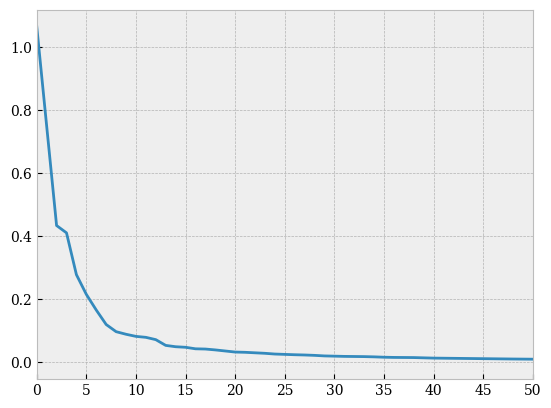

In [144]:
plt.plot(buyer_values)
plt.xlim(0, 50)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

In [10]:
ica = FastICA(n_components=n_components, max_iter=500)
ica.fit(X_b)

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


FastICA(max_iter=500, n_components=5)

In [11]:
ica.transform(np.cov(X_s, rowvar=False))

array([[-0.18232672, -0.46231394,  0.03358625,  0.0851643 ,  0.18145178],
       [-0.18100513, -0.46123753,  0.02602302,  0.08393484,  0.18437119],
       [-0.17827097, -0.4650165 ,  0.03390893,  0.08283448,  0.18330063],
       ...,
       [-0.18362342, -0.4597889 ,  0.02975498,  0.0833327 ,  0.18429983],
       [-0.17693659, -0.46194838,  0.02973034,  0.08512293,  0.18433249],
       [-0.18068611, -0.46110808,  0.02646782,  0.08461237,  0.18246717]])

### Compare different decompositions

In [157]:
decompositions = dict(
    PCA=PCA,
    # IncrementalPCA=IncrementalPCA,
    # KernelPCA=KernelPCA,
    # SparsePCA=SparsePCA,
    # FastICA=FastICA,
    # FactorAnalysis=FactorAnalysis,
    # DictionaryLearning=DictionaryLearning,
)

decomp_values = collections.defaultdict(dict)

for name, decomp in tqdm(decompositions.items()):
    threshold = 0.1
    n_components = 7
    omega = 0.1
    norm_volume=True
    kwargs= dict(
        threshold=threshold, 
        n_components=n_components, 
        omega = omega, 
        norm_volume=norm_volume,
        decomp=decomp,
        decomp_kwargs=dict(n_components=n_components) if name != 'SparseCoder' else {},
    )
    decomp_values[name]['buyer'] = get_value(buyer_data, buyer_data, **kwargs)
    decomp_values[name]['seller_1'] = get_value(buyer_data, seller_7_data, **kwargs)
    decomp_values[name]['seller_2'] = get_value(buyer_data, seller_7_data, **kwargs)
    decomp_values[name]['seller_3'] = get_value(buyer_data, seller_7_data, **kwargs)
    decomp_values[name]['seller_4'] = get_value(buyer_data, seller_7_data, **kwargs)
    decomp_values[name]['seller_5'] = get_value(buyer_data, seller_7_data, **kwargs)
    decomp_values[name]['seller_7'] = get_value(buyer_data, seller_7_data, **kwargs)
    decomp_values[name]['seller_7'] = get_value(buyer_data, seller_7_data, **kwargs)
    decomp_values[name]['seller_8'] = get_value(buyer_data, seller_8_data, **kwargs)
    decomp_values[name]['seller_9'] = get_value(buyer_data, seller_9_data, **kwargs)
    decomp_values[name]['seller_10'] = get_value(buyer_data, seller_10_data, **kwargs)
    decomp_values[name]['seller_11'] = get_value(buyer_data, seller_11_data, **kwargs)
    decomp_values[name]['seller_12'] = get_value(buyer_data, seller_12_data, **kwargs)
    decomp_values[name]['seller_13'] = get_value(buyer_data, seller_13_data, **kwargs)
    decomp_values[name]['seller_14'] = get_value(buyer_data, seller_14_data, **kwargs)
    decomp_values[name]['seller_15'] = get_value(buyer_data, seller_15_data, **kwargs)
    decomp_values[name]['seller_16'] = get_value(buyer_data, seller_16_data, **kwargs)
    decomp_values[name]['seller_17'] = get_value(buyer_data, seller_17_data, **kwargs)
    decomp_values[name]['seller_18'] = get_value(buyer_data, seller_18_data, **kwargs)
    decomp_values[name]['seller_19'] = get_value(buyer_data, seller_19_data, **kwargs)
    decomp_values[name]['seller_20'] = get_value(buyer_data, seller_20_data, **kwargs)
    decomp_values[name]['seller_21'] = get_value(buyer_data, seller_21_data, **kwargs)
    decomp_values[name]['seller_22'] = get_value(buyer_data, seller_22_data, **kwargs)
    decomp_values[name]['seller_23'] = get_value(buyer_data, seller_23_data, **kwargs)
    decomp_values[name]['seller_24'] = get_value(buyer_data, seller_24_data, **kwargs)
    decomp_values[name]['emnist'] = get_value(buyer_data, emnist_data, **kwargs)
    decomp_values[name]['fashion'] = get_value(buyer_data, fashion_data, **kwargs)
    decomp_values[name]['cifar'] = get_value(buyer_data, cifar_data, **kwargs)

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# where to save plots
figures = Path('figures')
figures.mkdir(exist_ok=True, parents=True)

/tmp/ipykernel_24083/3928501130.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.1f}' for x in ax.get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_24083/3928501130.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y for y in ax.get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_24083/3928501130.py:36: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=4)


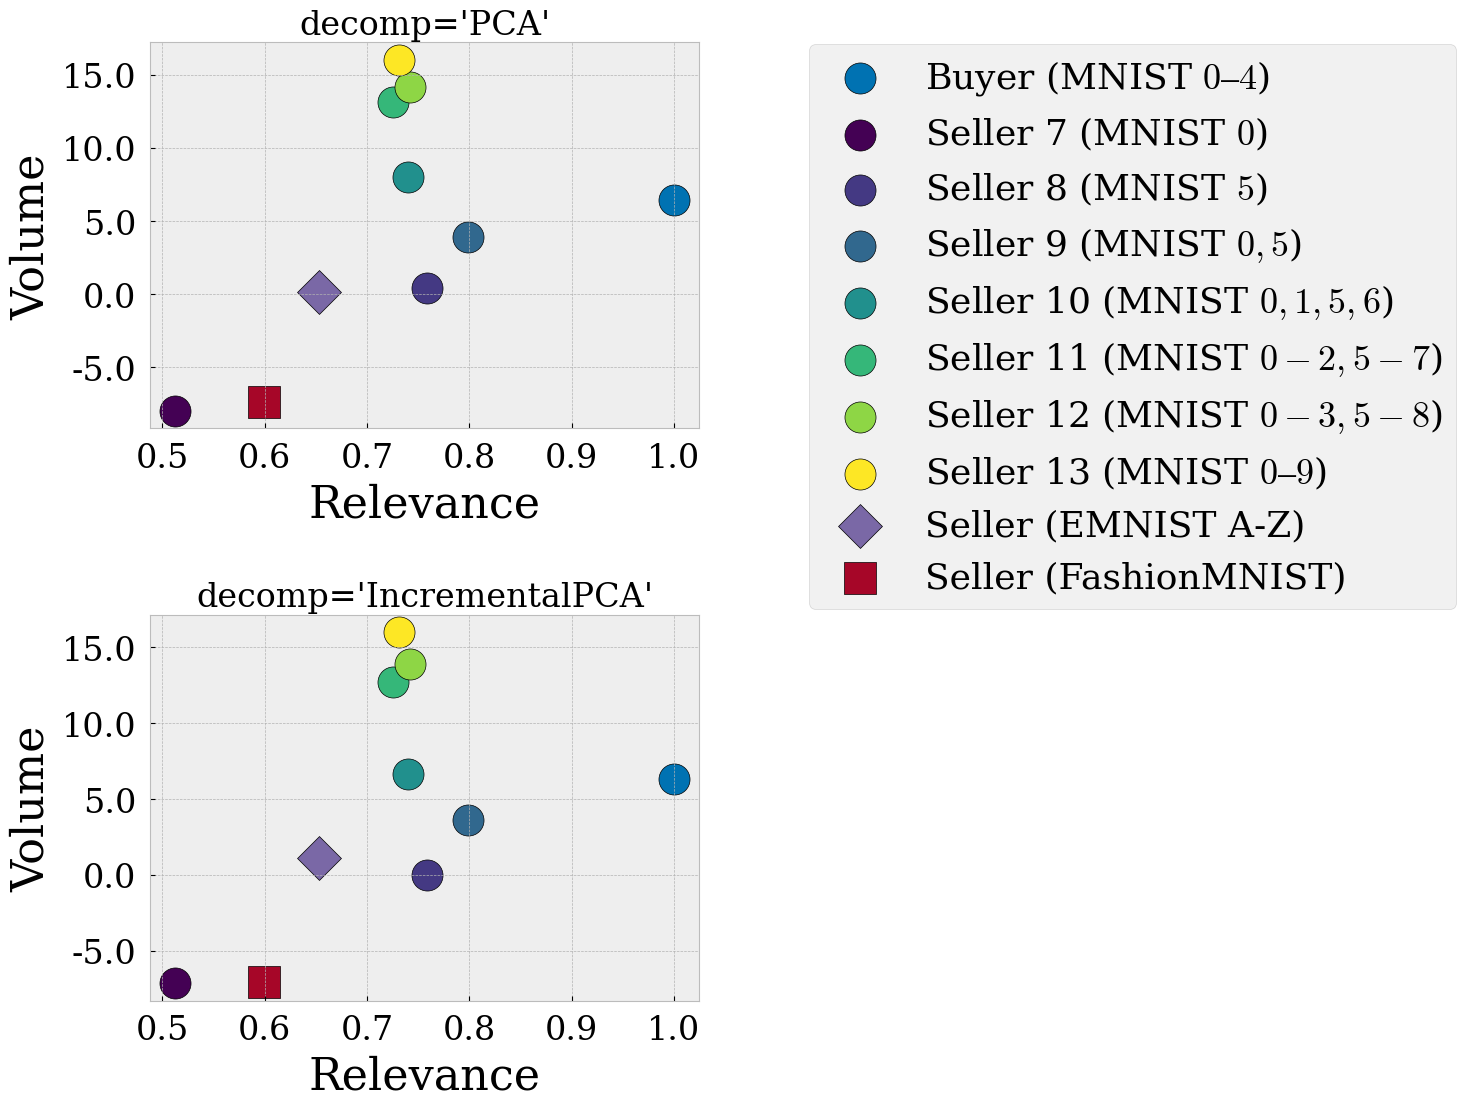

In [73]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 7)]
fontsize = 32
s = 500


fig, axs = plt.subplots(
    ncols=len(decompositions)//2,
    nrows=2,
    figsize=(4 * len(decompositions), 2 * 6),
    # facecolor="white",
    constrained_layout=True,
)

for i, (ax, (decomp, values)) in enumerate(zip(axs.flat, decomp_values.items())):
    ax.set_title(f'{decomp=}', fontsize=24)
    ax.scatter(values['buyer']['relevance'], values['buyer']['volume'], c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)' if i == 0 else None)
    ax.scatter(values['seller_7']['relevance'], values['seller_7']['volume'],  c=viridis[0], edgecolor='k', s=s, label=r'Seller 7 (MNIST $0$)' if i == 0 else None)
    ax.scatter(values['seller_8']['relevance'], values['seller_8']['volume'],  c=viridis[1], edgecolor='k', s=s, label=r'Seller 8 (MNIST $5$)' if i == 0 else None)
    ax.scatter(values['seller_9']['relevance'], values['seller_9']['volume'],  c=viridis[2], edgecolor='k', s=s, label=r'Seller 9 (MNIST $0, 5$)' if i == 0 else None)
    ax.scatter(values['seller_10']['relevance'], values['seller_10']['volume'],  c=viridis[3], edgecolor='k', s=s, label=r'Seller 10 (MNIST $0, 1, 5, 6$)' if i == 0 else None)
    ax.scatter(values['seller_11']['relevance'], values['seller_11']['volume'],  c=viridis[4], edgecolor='k', s=s, label=r'Seller 11 (MNIST $0-2, 5-7$)' if i == 0 else None)
    ax.scatter(values['seller_12']['relevance'], values['seller_12']['volume'],  c=viridis[5], edgecolor='k', s=s, label=r'Seller 12 (MNIST $0-3, 5-8$)' if i == 0 else None)
    ax.scatter(values['seller_13']['relevance'], values['seller_13']['volume'],  c=viridis[6], edgecolor='k', s=s, label=r'Seller 13 (MNIST $0–9$)' if i == 0 else None)
    ax.scatter(values['emnist']['relevance'], values['emnist']['volume'],  c='C2', edgecolor='k', s=s, marker='D', label=r'Seller (EMNIST A-Z)' if i == 0 else None)
    ax.scatter(values['fashion']['relevance'], values['fashion']['volume'],  c='C1', edgecolor='k', s=s, marker='s', label=r'Seller (FashionMNIST)' if i == 0 else None)
    # ax.scatter(values['cifar']['relevance'], values['cifar']['volume'],  c='C3', edgecolor='k', s=s, marker='^', label=r'Seller cifar' if i == 0 else None)
    
    # ax.set_xlim(0.0, 1.05)
    ax.set_xlabel('Relevance', fontsize=32, labelpad=6)
    ax.set_ylabel('Volume', fontsize=32, labelpad=6)
    ax.set_xticklabels([f'{x:.1f}' for x in ax.get_xticks()], fontsize=fontsize-8)
    ax.set_yticklabels([y for y in ax.get_yticks()], fontsize=fontsize-8)
    ax.tick_params(axis='both', which='major', pad=10)


fig.tight_layout(pad=4)
# fig.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.3, 0.94))
fig.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.9, 0.94))
plt.savefig(figures / f'mnist-compare-decompositions.pdf', bbox_inches='tight')
plt.show()

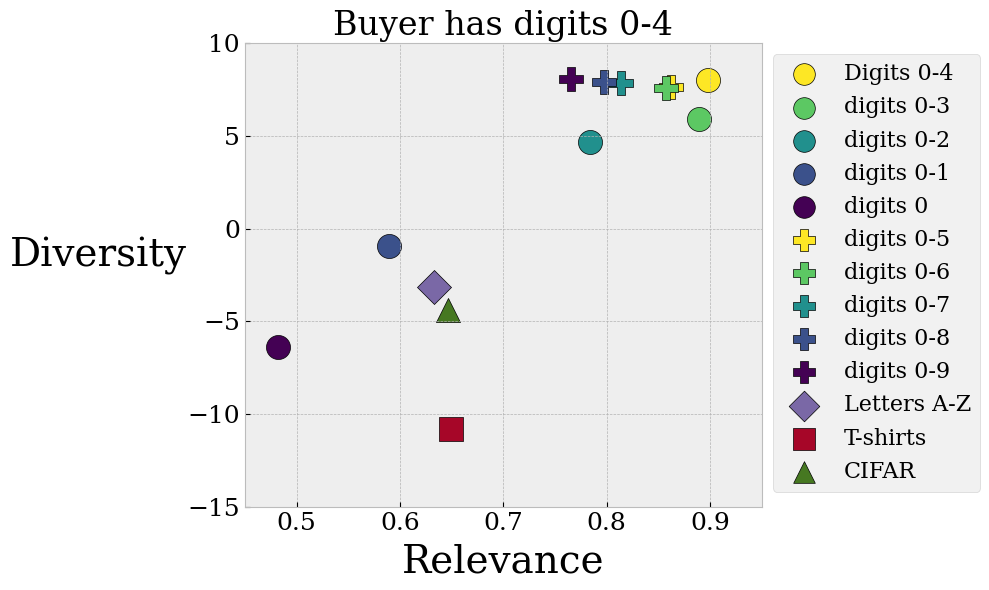

In [175]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 5)]
s = 300
values = decomp_values['PCA']
# plt.set_title(f'{decomp=}', fontsize=24)
plt.figure(figsize=(10, 6))
# plt.scatter(values['buyer']['relevance'], values['buyer']['volume'], c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)' )
plt.title('Buyer has digits 0-4', fontsize=24)
plt.scatter(values['seller_19']['relevance'], values['seller_19']['volume'],  c=viridis[4], edgecolor='k', s=s, label=r'Digits 0-4' )
plt.scatter(values['seller_18']['relevance'], values['seller_18']['volume'],  c=viridis[3], edgecolor='k', s=s, label=r'digits 0-3' )
plt.scatter(values['seller_17']['relevance'], values['seller_17']['volume'],  c=viridis[2], edgecolor='k', s=s, label=r'digits 0-2' )
plt.scatter(values['seller_16']['relevance'], values['seller_16']['volume'],  c=viridis[1], edgecolor='k', s=s, label=r'digits 0-1' )
plt.scatter(values['seller_15']['relevance'], values['seller_15']['volume'],  c=viridis[0], edgecolor='k', s=s, label=r'digits 0' )
plt.scatter(values['seller_20']['relevance'], values['seller_20']['volume'],  c=viridis[4], marker='P', edgecolor='k', s=s, label=r'digits 0-5' )
plt.scatter(values['seller_21']['relevance'], values['seller_21']['volume'],  c=viridis[3], marker='P', edgecolor='k', s=s, label=r'digits 0-6' )
plt.scatter(values['seller_22']['relevance'], values['seller_22']['volume'],  c=viridis[2], marker='P', edgecolor='k', s=s, label=r'digits 0-7' )
plt.scatter(values['seller_23']['relevance'], values['seller_23']['volume'],  c=viridis[1], marker='P', edgecolor='k', s=s, label=r'digits 0-8' )
plt.scatter(values['seller_24']['relevance'], values['seller_24']['volume'],  c=viridis[0], marker='P', edgecolor='k', s=s, label=r'digits 0-9' )
plt.scatter(values['emnist']['relevance'], values['emnist']['volume'],  c='C2', edgecolor='k', s=s, marker='D', label=r'Letters A-Z' )
plt.scatter(values['fashion']['relevance'], values['fashion']['volume'],  c='C1', edgecolor='k', s=s, marker='s', label=r'T-shirts' )
plt.scatter(values['cifar']['relevance'], values['cifar']['volume'],  c='C3', edgecolor='k', s=s, marker='^', label=r'CIFAR')

# plt.xlim(0.0, 1.05)
plt.xlabel('Relevance', fontsize=28, labelpad=6)
plt.ylabel('Diversity', fontsize=28, labelpad=64, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

# plt.tick_params(pltis='both', which='major', pad=10)
plt.xlim(0.45, 0.95)
plt.ylim(-15, 10)
plt.legend(bbox_to_anchor=(1, 1), fontsize=16, markerscale=0.9)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.tight_layout()
# plt.savefig('crit-1.png', bbox_inches='tight')
# plt.savefig('crit-2.png', bbox_inches='tight')
plt.savefig('crit-3.png', bbox_inches='tight')

'/u/luchar/data-valuation'